In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [2]:
train = pd.read_csv("FE_pima-indians-diabetes.csv")
train.head()

pregnants  Plasma_glucose_concentration  blood_pressure  \
0   0.639947                      0.866045       -0.031990   
1  -0.844885                     -1.205066       -0.528319   
2   1.233880                      2.016662       -0.693761   
3  -0.844885                     -1.073567       -0.528319   
4  -1.141852                      0.504422       -2.679076   

   Triceps_skin_fold_thickness  serum_insulin       BMI  \
0                     0.670643      -0.181541  0.166619   
1                    -0.012301      -0.181541 -0.852200   
2                    -0.012301      -0.181541 -1.332500   
3                    -0.695245      -0.540642 -0.633881   
4                     0.670643       0.316566  1.549303   

   Diabetes_pedigree_function       Age  Target  
0                    0.468492  1.425995       1  
1                   -0.365061 -0.190672       0  
2                    0.604397 -0.105584       1  
3                   -0.920763 -1.041549       0  
4                    5.484909 -0.020496       1

### 保存特征名字以备后用（可视化）

In [3]:
feat_names = train.columns 
print(feat_names)

Index(['pregnants', 'Plasma_glucose_concentration', 'blood_pressure',
       'Triceps_skin_fold_thickness', 'serum_insulin', 'BMI',
       'Diabetes_pedigree_function', 'Age', 'Target'],
      dtype='object')


## 准备数据

In [4]:
y = train['Target']   
X = train.drop(["pregnants", "Target"], axis=1)

## 默认参数的Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

### 正确率

In [7]:
from sklearn.model_selection import cross_val_score
loss = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
#%timeit loss_sparse = cross_val_score(lr, X_train_sparse, y_train, cv=3, scoring='neg_log_loss')
print ('logloss of each fold is: ',loss)
print ('cv logloss is:', (loss).mean())

logloss of each fold is:  [0.78571429 0.74675325 0.76623377 0.81045752 0.74509804]
cv logloss is: 0.7708513708513708


### 采用5折交叉验证和log似然损失

In [8]:
#需要调优的参数
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

from sklearn.model_selection import GridSearchCV
grid= GridSearchCV(lr, tuned_parameters, cv=5, scoring='neg_log_loss',n_jobs=4,verbose=5)
grid.fit(X,y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [9]:
print(-grid.best_score_)
print(grid.best_params_)

0.48483658874027397
{'C': 1, 'penalty': 'l1'}


D:\Users\Administrator\Anaconda3-5.3.1\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\Administrator\Anaconda3-5.3.1\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


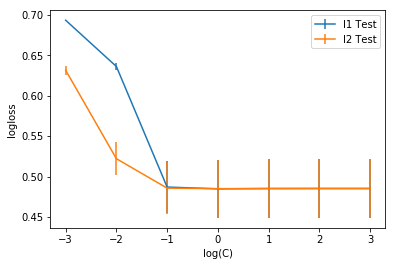

In [21]:
# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]


# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    #plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'logloss' )
plt.savefig('LogisticGridSearchCV_C.png' )

plt.show()

## 保存log似然损失的模型，用于后续测试

In [22]:
import _pickle as cPickle

cPickle.dump(grid.best_estimator_, open("log_loss.pkl", 'wb'))